# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
from pandas.io import sql
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sqlalchemy import create_engine
import csv
import numpy as np
import pandas as pd 
import plotly.graph_objs as go
import plotly.plotly as py
import psycopg2 as psy
import scipy
import seaborn as sns
import sklearn
py.sign_in('ajbentley', 'zjfu2vasav')



### Problem statement / aim for this project

#### Step 2: Load data to dataframe 

PostgreSQL created in Navicat.

In [4]:
cancel = pd.read_csv("../../projects-weekly/project-07_faa/assets/airport_cancellations.csv")

ops = pd.read_csv("../../projects-weekly/project-07_faa/assets/Airport_operations.csv")

ap = pd.read_csv("../../projects-weekly/project-07_faa/assets/airports.csv")


In [5]:

# there are a lot of airports in the ap list (5164 in all), most of which are outside of our scope and cause problems\
# later on so I'm going to do some housekeeping

# sorting by LocID
ap.sort_values(by='LocID', inplace=True)

# removing nas takes us down to 3498
ap.dropna(inplace=True)

# it looks like there are a bunch of counties without names. Takes us down to 3489
ap = pd.DataFrame(ap.loc[ap['COUNTY'] != "#NAME?"])

# "an airport served by scheduled route air-carrier or military airlift aircraft always has a code comprising
# of only three letters." 

# I'm going to remove any airport that has any numbers; taking out numbers brought us down to 2054

ap = ap[~ap['LocID'].str.contains("[\d]").fillna(False)]

# I think that's as far as I can get. I was really hoping to get it down to under 100

# ap.info()
# ap.head()


In [6]:
cancel.head(2)

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0


In [7]:
ops.head(2)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [8]:
cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

cancel.reset_index(drop=True, inplace=True)
ap.reset_index(drop=True, inplace=True)

df = cancel.join(ap, rsuffix='ap')
df.pop('AP_NAMEap');

df = df.join(ops, rsuffix='ops')
df.head()

,AP_NAME,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,LocID,ALIAS,Facility Type,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004.0,242.0,235.0,71.0,46.0,1196.0,AAA,Logan County Airport,Airport,...,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,776.0,AAF,Apalachicola Municipal Airport,Airport,...,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,1332.0,AAO,Colonel James Jabara Airport,Airport,...,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,1459.0,AAS,Taylor County Airport,Airport,...,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,484.0,AAT,Alturas Municipal Airport,Airport,...,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### Enhance / refine data

As the project focus is on current problems, including inability to course-correct (airports which are flat or worsening in delays) I'm going to:

1. merge the three available databases, eliminate anything that does not apply to delay measurements
2. create change metrics. while a more robust score could be determine, I'm using the change from 5 years prior.
3. eliminating all but the current year (2014)

In [9]:
# I bet later on we'll probably want to know what airports == airport initials so let's make a dictionary

airport_codes = pd.Series(ap.LocID)
airport_names = pd.Series(ap.AP_NAME)
ap_dict = dict(zip(airport_codes, airport_names))
ap_dict_list = zip(airport_codes, airport_names)
ap_dict_df = pd.DataFrame(ap_dict_list)
ap_dict_df.rename(columns = {0:'ap_code', 1:'airport'}, inplace=True)
ap_dict_df.sort_values(by='ap_code', inplace=True)

ap_dict_df.info()
ap_dict_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 0 to 2053
Data columns (total 2 columns):
ap_code    2054 non-null object
airport    2054 non-null object
dtypes: object(2)
memory usage: 48.1+ KB


,ap_code,airport
0,AAA,LOGAN COUNTY
1,AAF,APALACHICOLA REGIONAL
2,AAO,COLONEL JAMES JABARA
3,AAS,TAYLOR COUNTY
4,AAT,ALTURAS MUNI


In [10]:
# create df that only refs airport name, year, and delay and arrival information (continuous, not categorical data)


dfn = ['AP_NAME', 'Year', 'Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions',\
       'departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df[dfn])


dfn.columns = ['ap_name', 'year','D_cancel', 'A_cancel','D_divert','A_divert','D_4met','A_4met', 'pct_oT_gate_D',\
               'pct_oT_ap_D', 'pct_oT_gate_A', 'avg_taxi_out_time', 'avg_taxi_out_del', 'avg_ap_D_del',\
               'avg_airborne_del', 'avg_taxi_in_del', 'avg_block_del','avg_gate_A_del']



# dfn.head(15)

In [11]:
# Adding change columns for all continuous data 

dfn['Chg_D_cancel'] = dfn['D_cancel'].pct_change(5)
dfn['Chg_A_cancel'] = dfn['A_cancel'].pct_change(5)
dfn['Chg_D_divert'] = dfn['D_divert'].pct_change(5)
dfn['Chg_A_divert'] = dfn['A_divert'].pct_change(5)
dfn['Chg_D_4met'] = dfn['D_4met'].pct_change(5)
dfn['Chg_A_4met'] = dfn['A_4met'].pct_change(5)
dfn['Chg_pct_oT_gate_D'] = dfn['pct_oT_gate_D'].pct_change(5)
dfn['Chg_pct_oT_ap_D'] = dfn['pct_oT_ap_D'].pct_change(5)
dfn['Chg_pct_oT_gate_A'] = dfn['pct_oT_gate_A'].pct_change(5)
dfn['Chg_avg_taxi_out_time'] = dfn['avg_taxi_out_time'].pct_change(5)
dfn['Chg_avg_taxi_out_del'] = dfn['avg_taxi_out_del'].pct_change(5)
dfn['Chg_avg_ap_D_del'] = dfn['avg_ap_D_del'].pct_change(5)
dfn['Chg_avg_airborne_del'] = dfn['avg_airborne_del'].pct_change(5)
dfn['Chg_avg_taxi_in_del'] = dfn['avg_taxi_in_del'].pct_change(5)
dfn['Chg_avg_block_del'] = dfn['avg_block_del'].pct_change(5)
dfn['Chg_avg_gate_A_del'] = dfn['avg_gate_A_del'].pct_change(5)

dfn.head()

,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,...,Chg_pct_oT_gate_D,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971,53818,0.8030,0.7809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829,51877,0.8140,0.7922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682,51199,0.7983,0.7756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255,53611,0.8005,0.7704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589,49512,0.8103,0.7844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

df14 = pd.DataFrame(dfn.loc[df['Year'] == 2014])

df14.replace([np.inf, -np.inf], np.nan, inplace=True)
df14.dropna(inplace=True)
df14.drop(['year'], axis=1, inplace=True)

df14.head(69)

,ap_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,...,Chg_pct_oT_gate_D,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
10,ABQ,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,...,-0.106702,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918
21,ANC,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,...,0.021696,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630
32,ATL,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,...,0.015949,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093
43,AUS,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,...,-0.064631,-0.070628,-0.064508,0.007712,0.004878,0.274734,-0.004425,-0.068966,0.070632,0.272584
54,BDL,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,...,-0.047431,-0.042674,-0.045884,-0.019969,-0.107266,0.167072,-0.212121,0.104651,-0.098976,0.264103
65,BHM,336.0,311.0,46.0,30.0,23725,23682,0.7421,0.7183,0.7016,...,-0.046757,-0.024314,-0.057369,-0.015347,-0.361371,0.094771,-0.043956,0.273973,0.057762,0.164575
76,BNA,1266.0,1222.0,152.0,60.0,70497,70414,0.7404,0.7064,0.7364,...,-0.069966,-0.085211,-0.064414,0.068602,0.243119,0.296629,-0.291188,0.174757,0.106618,0.279070
87,BOS,2316.0,2330.0,349.0,121.0,170013,165166,0.8067,0.7295,0.7696,...,-0.017298,-0.026295,0.006145,-0.007096,-0.072356,0.005773,-0.234597,-0.012195,-0.234597,-0.075067
98,BUF,612.0,562.0,46.0,27.0,34314,34112,0.7584,0.7237,0.7376,...,-0.040122,-0.035324,-0.030749,-0.055124,-0.198675,0.067409,-0.300300,-0.300000,-0.185668,0.146552
109,BUR,427.0,403.0,36.0,39.0,30148,29885,0.7821,0.7613,0.7657,...,-0.071030,-0.082992,-0.078025,-0.003670,0.133721,0.368879,-0.145833,-0.087719,0.063584,0.415796


#### 1.2 What are the risks and assumptions of our data? 

While there is considerable information presented there is a massive amount of information that feels like it most be colinear (several flavors of delays and arrivals, all of which probably correlate highly). 

There's also data that would be useful, which I will address in the next steps at the end of this report. 
There is a mixture of measurement scales--total counts, coordinates, percentages, and minutes. Data will definitely need standardization to be usable.

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 805 non-null object
ALIAS                                 805 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

#### Creating new dataframe without change metrics for visualizations

In [14]:
nclist = df14.columns[1:16]
nclist

Index([u'D_cancel', u'A_cancel', u'D_divert', u'A_divert', u'D_4met',
       u'A_4met', u'pct_oT_gate_D', u'pct_oT_ap_D', u'pct_oT_gate_A',
       u'avg_taxi_out_time', u'avg_taxi_out_del', u'avg_ap_D_del',
       u'avg_airborne_del', u'avg_taxi_in_del', u'avg_block_del'],
      dtype='object')

In [15]:
df14nc = pd.DataFrame(df14[nclist])
df14nc.head()

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
10,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,10.64,2.41,15.99,1.73,1.02,2.40
21,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,11.33,1.33,12.34,4.09,0.54,4.57
32,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,17.40,4.92,15.93,2.74,2.77,3.21
43,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,11.76,2.06,15.59,2.25,1.08,2.88
54,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,12.76,2.58,14.39,2.34,0.95,2.64


In [16]:
# df14nc.hist(figsize=(20,20))

In [17]:
# sns.pairplot(df14nc, kind="scatter")

In [18]:
df14nc.describe()

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,1412.521739,1457.231884,174.579710,166.217391,102707.217391,102361.159420,0.760845,0.711397,0.759041,13.606522,3.283478,16.554928,2.622609,1.386087,3.150870
std,2030.302199,2184.822904,181.351009,221.172868,88841.995332,88749.797704,0.060968,0.073705,0.051796,3.302270,1.776569,4.049689,0.941164,0.834460,0.737501
min,17.000000,11.000000,3.000000,7.000000,955.000000,948.000000,0.577100,0.523300,0.584600,8.520000,0.860000,6.440000,1.260000,0.280000,1.840000
25%,429.000000,391.000000,57.000000,34.000000,35084.000000,35010.000000,0.723800,0.679900,0.728300,11.260000,2.150000,14.390000,1.960000,0.850000,2.630000
50%,654.000000,680.000000,88.000000,83.000000,67435.000000,66704.000000,0.768100,0.717200,0.756900,12.790000,2.710000,16.460000,2.430000,1.170000,3.050000
75%,1393.000000,1535.000000,213.000000,175.000000,166460.000000,164346.000000,0.795300,0.751800,0.783100,15.440000,3.970000,18.980000,3.090000,1.740000,3.750000
max,13454.000000,14355.000000,781.000000,1164.000000,428954.000000,428312.000000,0.900700,0.888100,0.878400,25.100000,11.210000,25.920000,6.410000,4.950000,5.130000


#### Do the data have normal distribution?

The histograms make it clear that they do not. Most of these measurements are right skewed, often heavily so. 

The mean and median reflected in the describe output confirm that these are not normally distributed.

#### Find correlations between the data

In [19]:
df_corr = abs(df14nc.corr())

df_corr = df_corr.applymap(lambda x: x if x >= 0.9 else '')
df_corr

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del
D_cancel,1,0.998873,,,,,,,,,,,,,
A_cancel,0.998873,1,,,,,,,,,,,,,
D_divert,,,1,,,,,,,,,,,,
A_divert,,,,1,,,,,,,,,,,
D_4met,,,,,1,0.999935,,,,,,,,,
A_4met,,,,,0.999935,1,,,,,,,,,
pct_oT_gate_D,,,,,,,1,,,,,,,,
pct_oT_ap_D,,,,,,,,1,,,,0.948584,,,
pct_oT_gate_A,,,,,,,,,1,,,,,,
avg_taxi_out_time,,,,,,,,,,1,,,,,


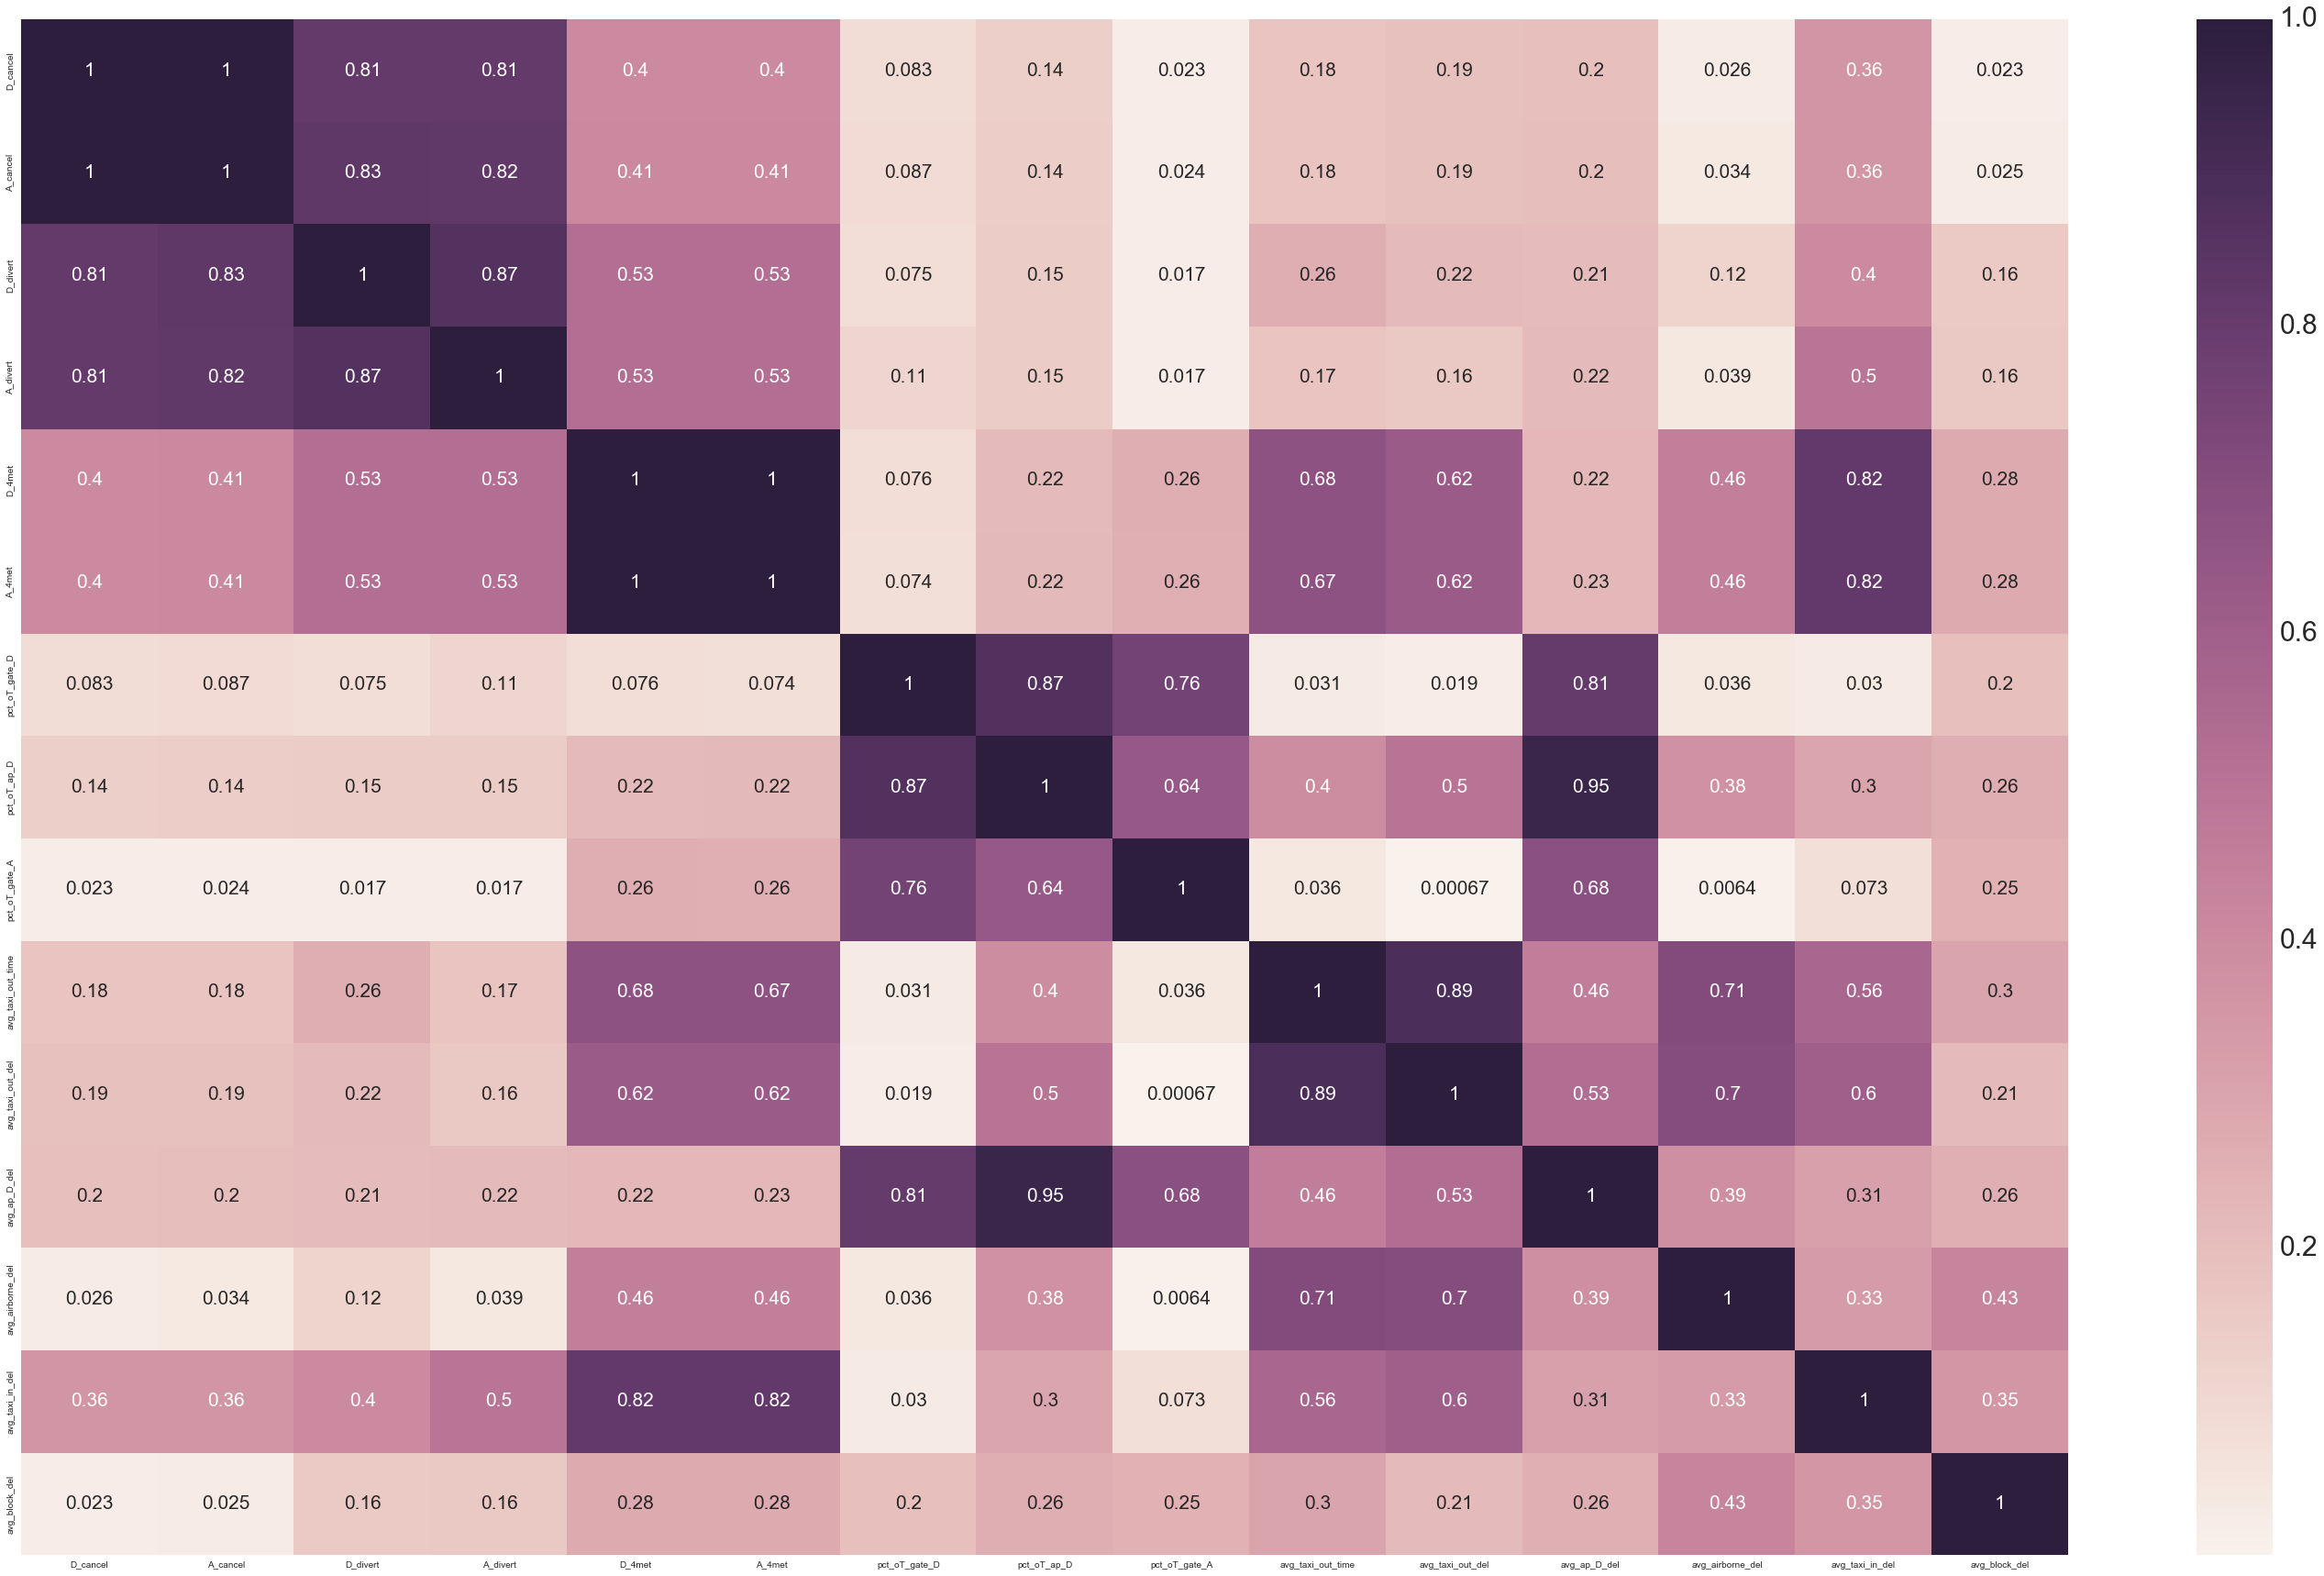

In [20]:
df_corr = abs(df14nc.corr())

df_corr.replace([np.inf, -np.inf], np.nan, inplace=True)
df_corr.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(50,30))   
sns.set(font_scale=3)
ax = sns.heatmap(df_corr, annot=True, annot_kws={"size": 21})

#### 4.3 What is the value of understanding correlations before PCA?

My original thought had been that you would want to check for colinearity between features before pouring them into PCs but the more I think of it the less sense that makes. Shouldn't the PCA process effectively downgrade extraneous information?

In previous incarnations of this project I did considerable work with removing features to improve PCA but found the practice had little impact. Below is a description of one such analysis:

> Checking for pairs with correlations >.95. Will exclude the one of the pair with the greater sum of absolute correlations for all features (the one that has more of its explanatory power already covered by other features). If there is a tie (or close to) I'll favor delays over arrivals.

> * A - Departure Cancellations and Arrival Cancellations .999 correlated, dropping Arrival Cancellations
> * B - Deparetures for Metric Computations and Arrivals for Metric Computations .999 correlated, dropping Arrivals
> * C - Average Airport Departure Delay and Percent on-time airport departures -.96 correlated, dropping Average Airport Departure Delay
> * D - Average Gate Arrival Delay and Percent on-time gate arrivals -.95 correlated, dropping Percent on-time Gate Arrivals.

> Had first done this naive--none of the above exclusions.

> After doing this my cumed eigenvalues declined. Testing to see whether I should have done different exclusions if any.

> * Naive 
> * i. ABCD excluded 
> * ii. ABC excluded 
> * iii. ABD excluded 
> * iv. ACD excluded 
> * v. BCD excluded 
> * vi. inverse ABCD (excluded the other partner in the pair) 
> * vii. iABC excluded 
> * viii. iABD excluded 
> * ix. iACD excluded 
> * x. iBCD excluded


>  Data: Cum PC1 / PC2 / PC3
> * 36 / 66 / 82 
> * i. 37 / 62 / 79 
> * ii. 34 / 64 / 80 
> * iii. 37 / 64 / 80 
> * iv. 40 / 64 / 80 
> * v. 38 / 62 / 80 
> * vi. 37 / 62 / 80 
> * vii. 35 / 64 / 81 
> * viii. 36 / 65 / 81 
> * ix. 41 / 64 / 80 
> * x. 38 / 62 / 81

> From this analysis I can see that dropping factors based on correlation is actually harmful and that I had been targeting the wrong member of the correlated pairs.

> As a last test I'll look at dropping only one of the inverse members at a time:
> * dropping iA: 36 / 67 / 81 
> * dropping iB: 35 / 65 / 82 
> * dropping iC: 38 / 64 / 81 
> * dropping iD: 38 / 65 / 81

> So it looks like excluding for correlation is the wrong way to go.

### Part 5: Perform a PCA

In [21]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 10 to 793
Data columns (total 33 columns):
ap_name                  69 non-null object
D_cancel                 69 non-null float64
A_cancel                 69 non-null float64
D_divert                 69 non-null float64
A_divert                 69 non-null float64
D_4met                   69 non-null int64
A_4met                   69 non-null int64
pct_oT_gate_D            69 non-null float64
pct_oT_ap_D              69 non-null float64
pct_oT_gate_A            69 non-null float64
avg_taxi_out_time        69 non-null float64
avg_taxi_out_del         69 non-null float64
avg_ap_D_del             69 non-null float64
avg_airborne_del         69 non-null float64
avg_taxi_in_del          69 non-null float64
avg_block_del            69 non-null float64
avg_gate_A_del           69 non-null float64
Chg_D_cancel             69 non-null float64
Chg_A_cancel             69 non-null float64
Chg_D_divert             69 non-null float64


In [22]:
# Declaring my features and separating out the airport names

x2 = df14.ix[:,1:33].values
y2 = df14.ix[:,0].values


# scaling the feature values so that PCA may work
xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df14.columns[1:33])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

In [23]:
# fit standardized data for PCA

pca2 = PCA(n_components=2)
X = pca2.fit_transform(xStand)

In [24]:
# a bunch of pca eigenstuffs

covMat = np.cov(X.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0]);

7.04907196122
6.54243768978


In [25]:
# show what variance is explained by each CP

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  51.86378954  100.        ]


In [26]:
# Let's see the PCs and make a DF out of them for future use

PCAdf2 = pd.DataFrame(X, columns=['PC1','PC2'])
j = PCAdf2.PC1
k = PCAdf2.PC2

PCAdf2.head()

,PC1,PC2
0,3.630733,-0.645313
1,-2.550770,-3.053331
2,-6.844147,2.887877
3,1.683843,-0.631700
4,0.879509,-1.814200


In [27]:
# Let's see how closely related each PC is to the original features

PCPieces = abs(pd.DataFrame(pca2.components_, columns = df14.columns[1:33], index = ['PC1', 'PC2']))
PCPieces.T.sort_values('PC1', ascending = False).head(30)

,PC1,PC2
Chg_pct_oT_gate_A,0.330749,0.086751
Chg_pct_oT_ap_D,0.311219,0.093743
Chg_avg_ap_D_del,0.304368,0.119327
Chg_avg_gate_A_del,0.302912,0.109161
Chg_pct_oT_gate_D,0.297262,0.101353
pct_oT_gate_D,0.239036,0.205675
pct_oT_gate_A,0.232829,0.170504
D_4met,0.222301,0.238506
A_4met,0.221371,0.238927
Chg_avg_block_del,0.195719,0.089274


Interesting to see that the change metrics were so strong.

Also interesting, regarding the correlations, some highly correlated pairs saw neither measurement supplying much impact. 

In [28]:
# more eigenstuffs

eigen_pairs = [[eigenValues[i], eigenVectors[:,i]] for i in range(len(eigenValues))]
eigen_pairs.sort(reverse=True)

weight_2d_projection = np.hstack((eigen_pairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigen_pairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection;


Weight data 2d PCA projection matrix:
[[  1.00000000e+00   1.27498243e-14]
 [ -1.27498243e-14   1.00000000e+00]]


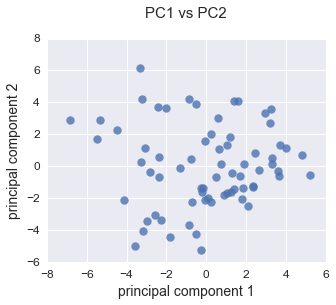

In [29]:
# Let's plot this out

fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=14)
ax.set_ylabel('principal component 2', fontsize=14)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=15
            )

plt.show()

No strong patterns apparent

### Part 6: Additional Analysis

Step 1 was to get PCs so now we're ready for step 2, clustering. 

I'll use DB-SCAN to start, since it's the coolest.

In [30]:
db = DBSCAN(eps =2.4, min_samples=3)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.145


In [31]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 1
Silhouette Coefficient: -0.162


Still looking at a single cluster. I'm going to revisit my earlier decision to only use 2014 data and will expand to prior three years, hoping that additional data will improve the analysis.

Going back to the start with a new PCA.

In [32]:
# Creating dataframe of years 2012 and later to bolster analysis

df1214 = pd.DataFrame(dfn.loc[df['Year'] >= 2012])

df1214.replace([np.inf, -np.inf], np.nan, inplace=True)
df1214.dropna(inplace=True)

df1214.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 8 to 803
Data columns (total 34 columns):
ap_name                  211 non-null object
year                     211 non-null float64
D_cancel                 211 non-null float64
A_cancel                 211 non-null float64
D_divert                 211 non-null float64
A_divert                 211 non-null float64
D_4met                   211 non-null int64
A_4met                   211 non-null int64
pct_oT_gate_D            211 non-null float64
pct_oT_ap_D              211 non-null float64
pct_oT_gate_A            211 non-null float64
avg_taxi_out_time        211 non-null float64
avg_taxi_out_del         211 non-null float64
avg_ap_D_del             211 non-null float64
avg_airborne_del         211 non-null float64
avg_taxi_in_del          211 non-null float64
avg_block_del            211 non-null float64
avg_gate_A_del           211 non-null float64
Chg_D_cancel             211 non-null float64
Chg_A_cancel             2

In [33]:
# all the same PCA stuff I did before

x2 = df1214.ix[:,2:34].values

xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df1214.columns[2:34])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

pca2 = PCA(n_components=2)
X = pca2.fit_transform(xStand)

covMat = np.cov(X.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)


[  54.64983141  100.        ]


In [34]:
PCAdf2 = pd.DataFrame(X, columns=['PC1','PC2'])
j = PCAdf2.PC1
k = PCAdf2.PC2

PCAdf2.head()

,PC1,PC2
0,-3.063637,-1.720386
1,-0.202416,-2.422799
2,2.647424,-3.277333
3,-4.038437,-0.402134
4,-3.932380,-0.733440


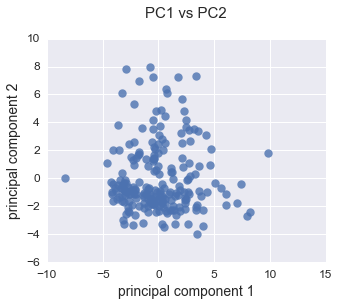

In [35]:
fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=14)
ax.set_ylabel('principal component 2', fontsize=14)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=15
            )

plt.show()

Okay, that's a little blobbier. Let's see what DB-SCAN can make of it.

In [36]:
db = DBSCAN(eps =1.5, min_samples=3)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.118


In [37]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 2
Silhouette Coefficient: -0.166



2 clusters! Huzzah!

/Users/EKandTower/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



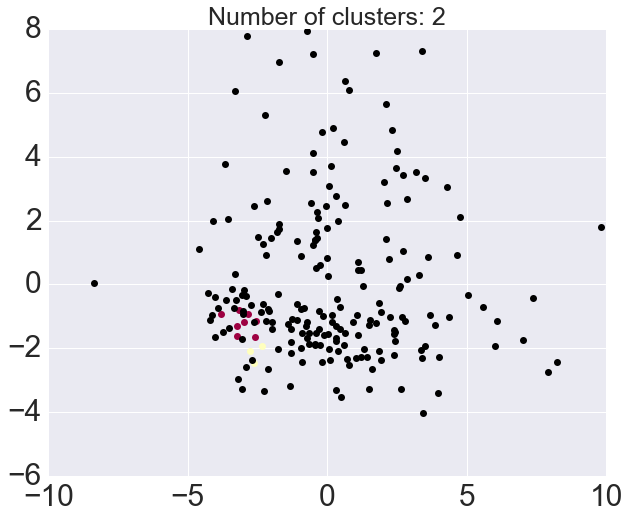

In [38]:
# I'm pretty sure I got a bunch of this stuff from Peida

fig = plt.figure(figsize=(10,8))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=7)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=7)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

plt.title('Number of clusters: %d' % n_clusters_, fontsize=25);


In [39]:
# Rerunning PCA to get 3 components

xStand = pd.DataFrame(StandardScaler().fit_transform(x2), columns=df1214.columns[2:34])
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(xStand)

covMat = np.cov(X3.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()

totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  41.35543711   75.67349439  100.        ]



So it's mostly noise with a little signal in there somewhere. Maybe we need to look at the data a little differently...

## in 3D!

In [40]:
PCAdf3 = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
j = PCAdf3.PC1
k = PCAdf3.PC2
l = PCAdf3.PC3

PCAdf3.head()

,PC1,PC2,PC3
0,-3.063637,-1.720386,0.375925
1,-0.202416,-2.422799,-0.521408
2,2.647424,-3.277333,-1.231126
3,-4.038437,-0.402134,1.259091
4,-3.932380,-0.733440,1.399758


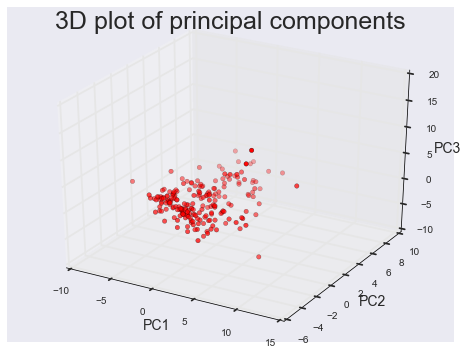

In [41]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = j, ys = k, zs = l, c=('R','G','B'))
ax.set_xlabel('PC1', fontsize=14);
ax.set_ylabel('PC2', fontsize=14);
ax.set_zlabel('PC3', fontsize=14);
ax.set_title("3D plot of principal components", fontsize = 25)

plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 


plt.show()
    

I doubt DB-SCAN will do any better with this, but let's give it a try

In [42]:
db = DBSCAN(eps =1.8, min_samples=4)
db.fit(xStand)

core_samples = db.core_sample_indices_
labels = db.labels_

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: -0.283


In [43]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 2
Silhouette Coefficient: -0.244


so that definitely didn't help. Time to get K-Mean about things.

In [44]:
k_list = [2, 3, 4,5,6]

for k in k_list:
    kmean = KMeans(n_clusters=k)
    kmean.fit(x2)
    random_state = 43
    print k, silhouette_score(x2, kmean.labels_), kmean.inertia_
    print

2 0.693676322538 930855570804.0

3 0.676942964096 464953183297.0

4 0.57564216532 293354720239.0

5 0.586572793673 170691899323.0

6 0.593863408615 111047067958.0



Inertia for 2 clusters is so much stronger than for anything further that it's hard to justify using more, but one of the issues I'm trying to address with this is a lack of clusters.

I'll try mapping out 2, 3, and 4 and see what looks best.

In [45]:
# running k-means for 2 clusters

chosen_k = 2

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

kmean_df = pd.concat([PCAdf3,label], axis = 1)
kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


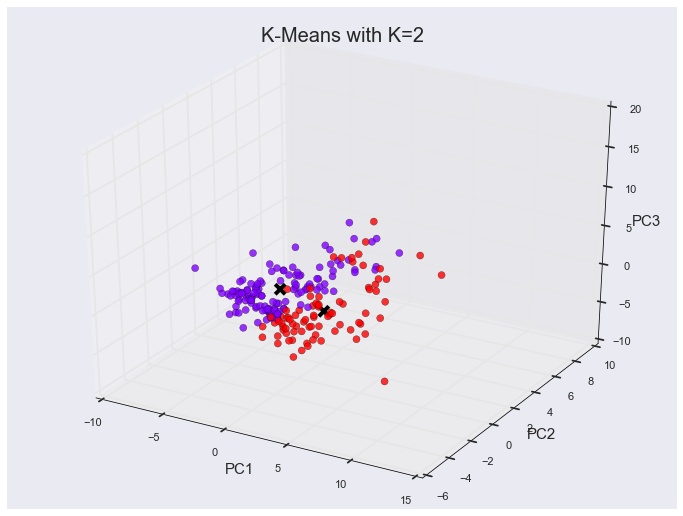

In [46]:
# visualizing k-means with 2 cluster

centroid = pd.DataFrame(kmean.cluster_centers_, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = centroid['PC1'] , ys = centroid['PC2'], zs = centroid['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=2', fontsize = 20)

plt.show()

well that looks pretty sweet!

In [47]:
# running k-means for 3 clusters

chosen_k = 3

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

centroids = kmean.cluster_centers_

kmean_df = pd.concat([PCAdf3,label], axis = 1)


kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


In [48]:
# looking at how many airports are in each of these PCs
kmean_df['label'].value_counts()

0    104
1     66
2     41
Name: label, dtype: int64

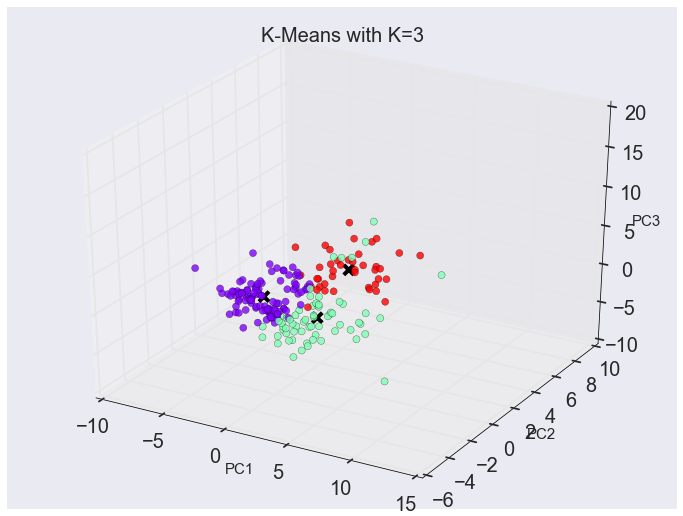

In [49]:
# visualizing k-means with 3 clusters

pcakm = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs = pcakm['PC1'] , ys = pcakm['PC2'], zs = pcakm['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=3', fontsize = 20)

plt.show()


even better! let's see 4 and be done for the day'

In [50]:
# running k-means for 4 clusters

chosen_k = 4

kmean = KMeans(n_clusters=chosen_k, random_state=43)
kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

kmean_df = pd.concat([PCAdf3,label], axis = 1)
kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,2
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


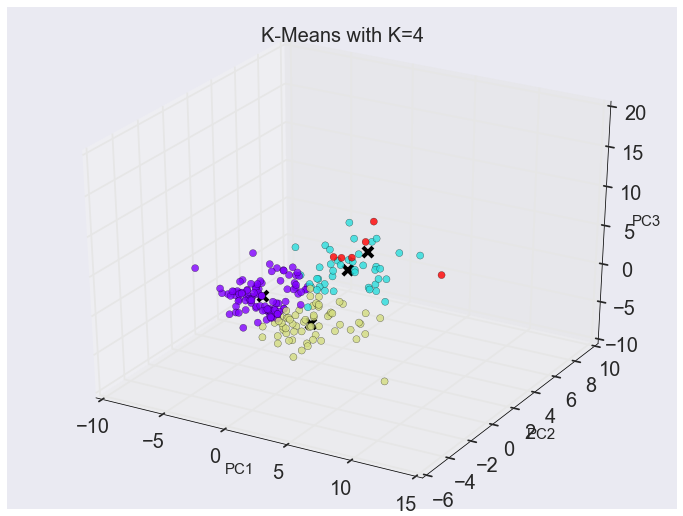

In [51]:
# visualizing k-means with 4 clusters

centroid = pd.DataFrame(kmean.cluster_centers_, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(xs = centroid['PC1'] , ys = centroid['PC2'], zs = centroid['PC3'], \
           s = 100, c = 'black', marker = 'x', linewidth = 4, alpha = 1.0)
ax.scatter(xs = kmean_df['PC1'] , ys = kmean_df['PC2'], zs=kmean_df['PC3'], alpha = 0.8, \
           s = 50, c = kmean_df['label'], cmap = 'rainbow')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ax.set_title('K-Means with K=4', fontsize = 20)
plt.show()

Let's go with 3--that fourth one is bleh (technically speaking)
Did you catch how I used different variable names for the 3rd cluster? Foreshadowing!

In [52]:
# rerunning the clusters for k=3 for use in the next steps

chosen_k = 3

kmean = KMeans(n_clusters=chosen_k, random_state=43)
clusters = kmean.fit(PCAdf3)
    
label = pd.Series(kmean.labels_, name = 'label')

centroids = kmean.cluster_centers_

kmean_df = pd.concat([PCAdf3,label], axis = 1)


kmean_df.head()

,PC1,PC2,PC3,label
0,-3.063637,-1.720386,0.375925,0
1,-0.202416,-2.422799,-0.521408,0
2,2.647424,-3.277333,-1.231126,1
3,-4.038437,-0.402134,1.259091,0
4,-3.932380,-0.733440,1.399758,0


## Okay, now we've got our clusters. 

## The next step is to use them to ID the airports that have the problems

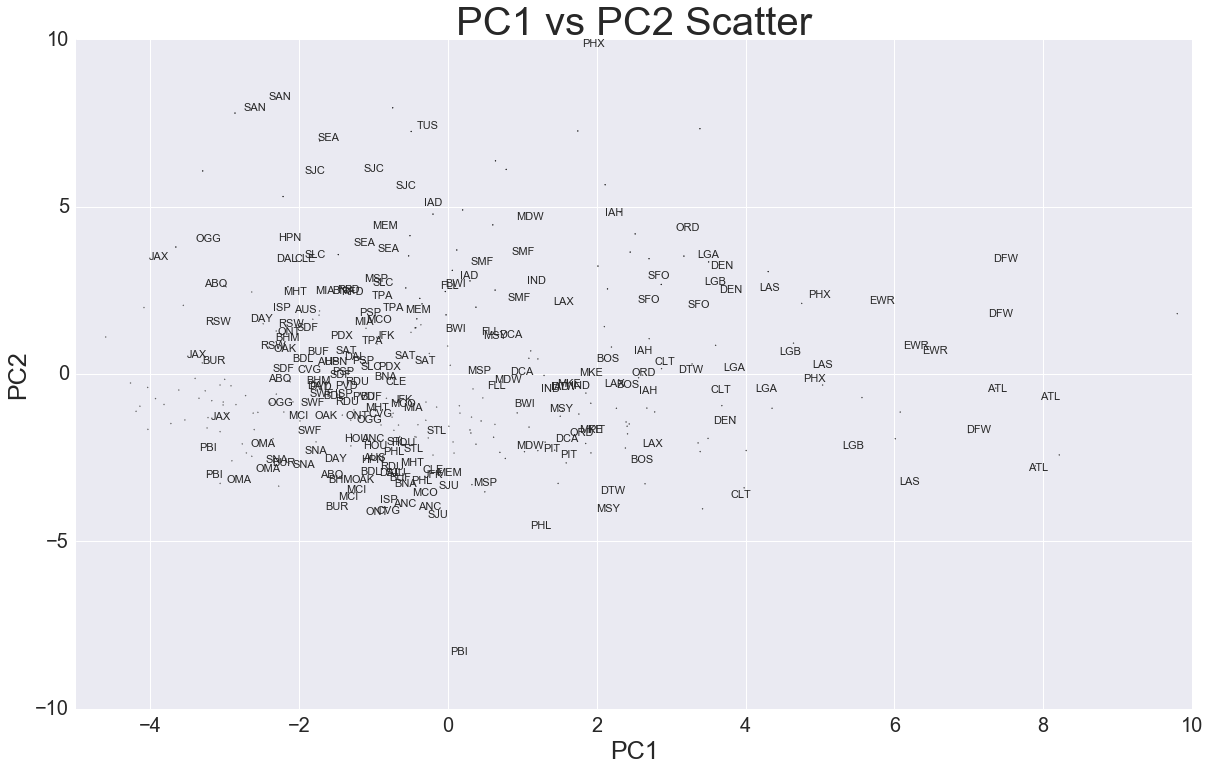

In [53]:
# graph that shows the airport names on the cluster map
graph1 = kmean_df.plot(
    kind = "scatter",
    x = 'PC1', y='PC2',
    c = kmean_df.label.astype(np.float),
      s = 1,
    figsize = (20,12))
graph1.set_xlabel('PC1', fontsize=25)
graph1.set_ylabel('PC2', fontsize=25)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 

graph1.set_title('PC1 vs PC2 Scatter', fontsize = 40)

plt.axis([-5,10, -10,10])
graph1 = plt.gca()
graph1.set_autoscale_on(False)

for i, airport in enumerate (df1214['ap_name']):
    graph1.annotate(airport, (kmean_df.iloc[i].PC2, kmean_df.iloc[i].PC1), size=11)

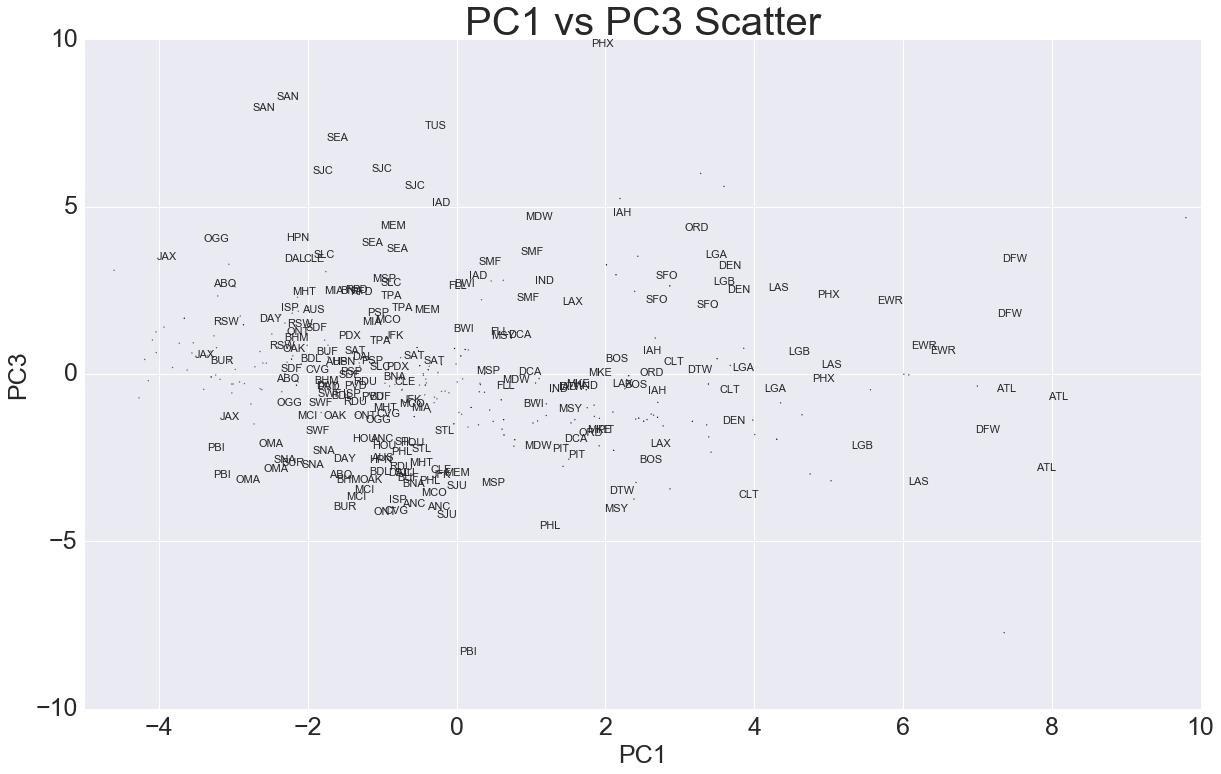

In [54]:
    
    
# graph that shows the airport names on the cluster map
graph2 = kmean_df.plot(
    kind = "scatter",
    x = 'PC1', y='PC3',
    c = kmean_df.label.astype(np.float),
      s = 1,
    figsize = (20,12))
graph2.set_xlabel('PC1', fontsize=25)
graph2.set_ylabel('PC3', fontsize=25)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 

graph2.set_title('PC1 vs PC3 Scatter', fontsize = 40)

plt.axis([-5,10, -10,10])
graph2 = plt.gca()
graph2.set_autoscale_on(False)
    for i, airport in enumerate (df1214['ap_name']):
        graph2.annotate(airport, (kmean_df.iloc[i].PC2, kmean_df.iloc[i].PC1), size=11)

    

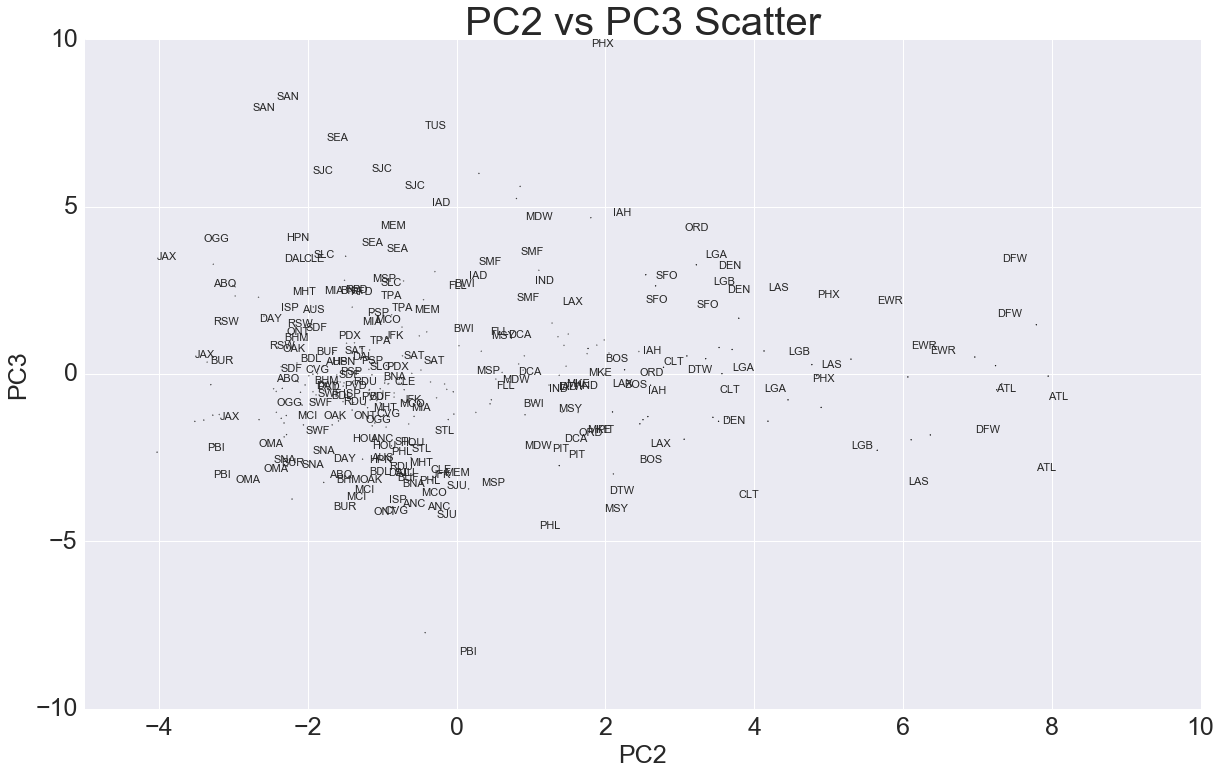

In [55]:
# graph that shows the airport names on the cluster map
graph3 = kmean_df.plot(
    kind = "scatter",
    x = 'PC2', y='PC3',
    c = kmean_df.label.astype(np.float),
      s = 1,
    figsize = (20,12))
graph3.set_xlabel('PC2', fontsize=25)
graph3.set_ylabel('PC3', fontsize=25)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 

graph3.set_title('PC2 vs PC3 Scatter', fontsize = 40)

plt.axis([-5,10, -10,10])
graph3 = plt.gca()
graph3.set_autoscale_on(False)

for i, airport in enumerate (df1214['ap_name']):
    graph3.annotate(airport, (kmean_df.iloc[i].PC2, kmean_df.iloc[i].PC1), size=11)



In [56]:
# Make a dataframe of the airports by cluster label

kml = pd.DataFrame(kmean.labels_)

kml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 1 columns):
0    211 non-null int32
dtypes: int32(1)
memory usage: 916.0 bytes


In [57]:
# and now a new dataframe that includes the airport data with the cluster label data

df1214.reset_index(drop=True, inplace=True)
kml.reset_index(drop=True, inplace=True)

dfc = pd.concat([df1214,kml], axis = 1)

print len(dfc)
dfc.head()

211


,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,...,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,0
0,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461,0
1,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498,0
2,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,1
3,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245,0
4,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590,0


In [58]:
# a little head cleaning

dfc.rename(columns={0:'cluster'}, inplace=True)

# give the clusters nicer names

def new_name(x):
    if x == 0:
        return "Cluster A"
    elif x == 1:
        return "Cluster B"
    else:
        return "Cluster C"
    
dfc['cluster_name'] = dfc['cluster'].apply(new_name);

dfc.pop('cluster')

print len(dfc)
dfc.head()

211


,ap_name,year,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,...,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,cluster_name
0,ABQ,2012.0,237.0,181.0,65.0,60.0,39105,39107,0.8219,0.7940,...,0.030633,0.069308,-0.006770,-0.033333,-0.064865,-0.356164,-0.240310,-0.411765,-0.234461,Cluster A
1,ABQ,2013.0,232.0,212.0,62.0,46.0,35277,34989,0.7710,0.7402,...,-0.056349,-0.040762,0.034582,0.095436,0.159091,-0.120879,-0.106796,-0.157706,0.111498,Cluster A
2,ABQ,2014.0,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,Cluster B
3,ANC,2012.0,216.0,284.0,78.0,36.0,70322,66453,0.8442,0.8235,...,0.104332,0.184130,-0.112206,-0.336245,-0.372146,-0.247563,-0.128205,-0.361158,-0.484245,Cluster A
4,ANC,2013.0,141.0,184.0,65.0,40.0,69984,65469,0.8432,0.8228,...,0.068849,0.139707,-0.104911,-0.188172,-0.314538,-0.337232,-0.253968,-0.355818,-0.467590,Cluster A


Since we have our clusters now, we don't really need that pesky old 2012-2013 data anymore (besides, it'll just make it more frustrating to clean up later) so we'll pare it back down to 2014 now.

In [59]:
df14c = pd.DataFrame(dfc)
df14c = pd.DataFrame(df14c.loc[df14c['year'] == 2014])

df14c.drop(['year'], axis=1, inplace=True)

print len(df14c)
df14c.head()

69


,ap_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,...,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del,cluster_name
2,ABQ,315.0,274.0,66.0,37.0,33292,33137,0.7451,0.7148,0.7320,...,-0.122622,-0.109922,0.076923,0.275132,0.530144,-0.005747,0.108696,0.212121,0.587918,Cluster B
5,ANC,111.0,162.0,74.0,28.0,71099,66704,0.8288,0.8074,0.8600,...,0.015342,0.040658,-0.092874,-0.141935,-0.222922,0.062338,0.741935,0.090692,-0.321630,Cluster A
8,ATL,5977.0,6483.0,781.0,655.0,428954,428312,0.7899,0.7134,0.8123,...,0.209153,0.107430,-0.203297,-0.494347,-0.258380,-0.172205,-0.416842,-0.436842,-0.249093,Cluster C
11,AUS,484.0,435.0,88.0,97.0,60588,60264,0.7627,0.7382,0.7222,...,-0.070628,-0.064508,0.007712,0.004878,0.274734,-0.004425,-0.068966,0.070632,0.272584,Cluster B
14,BDL,467.0,421.0,57.0,32.0,39279,39109,0.7953,0.7605,0.7569,...,-0.042674,-0.045884,-0.019969,-0.107266,0.167072,-0.212121,0.104651,-0.098976,0.264103,Cluster B


### Let's meet our clusters!

In [60]:
# let's make a dataframe that gives us our clusters, the airport code, and airport name

# first grab the code and cluster number from the new dataframe that matched them. Also grab the\
#   Departures total so we can get an idea of how big each one is

cluster_meet = ['ap_name','cluster_name', 'D_4met']
clusters = pd.DataFrame(df14c[cluster_meet])

clusters.rename(columns={'ap_name':'ap_code'}, inplace=True)

# # then reset the indeces for that df and the df dictionary made earlier so that they can merge nicely
clusters.reset_index(drop=True, inplace=True)
ap_dict_df.reset_index(drop=True, inplace=True)


# #bring them both together
clustdf = pd.merge(ap_dict_df, clusters, how='right', sort='True', on=['ap_code'])


# # move columns around a bit
# clusters[['cluster_name', 'D_4met', 'ap_code','airport']] = clusters[['cluster_name','ap_code','airport','D_4met']]
# clusters.rename(columns={'D_4met':'ap_code', 'ap_code':'airport', 'airport':'Total Departures'}, inplace = True)

# # clean the head
# clusters.pop('ap_name');

# # voila!
clustdf.info()
clustdf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 4 columns):
ap_code         69 non-null object
airport         68 non-null object
cluster_name    69 non-null object
D_4met          69 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.7+ KB


,ap_code,airport,cluster_name,D_4met
0,ABQ,ALBUQUERQUE INTL SUNPORT,Cluster B,33292
1,ANC,TED STEVENS ANCHORAGE INTL,Cluster A,71099
2,ATL,HARTSFIELD - JACKSON ATLANTA INTL,Cluster C,428954
3,AUS,AUSTIN-BERGSTROM INTL,Cluster B,60588
4,BDL,BRADLEY INTL,Cluster B,39279


In [61]:
# Now we're ready to see each cluster individually

# isolating Cluster A
cluster0 = pd.DataFrame(clustdf.loc[clustdf['cluster_name'] == 'Cluster A'])

# sorting by ap_code and resetting the index
cluster0.sort_values(by='ap_code', inplace=True)

cluster0.reset_index(drop=True, inplace=True)

print cluster0.describe()
cluster0.head(50)

              D_4met
count      20.000000
mean    68145.950000
std     52924.982188
min       955.000000
25%     36038.750000
50%     59632.500000
75%     89021.750000
max    205899.000000


,ap_code,airport,cluster_name,D_4met
0,ANC,TED STEVENS ANCHORAGE INTL,Cluster A,71099
1,CVG,CINCINNATI/NORTHERN KENTUCKY INTL,Cluster A,61186
2,DTW,DETROIT METROPOLITAN WAYNE COUNTY,Cluster A,192007
3,HOU,WILLIAM P HOBBY,Cluster A,90752
4,MCI,KANSAS CITY INTL,Cluster A,14641
5,OMA,EPPLEY AIRFIELD,Cluster A,34163
6,PBI,PALM BEACH INTL,Cluster A,955
7,PDX,PORTLAND INTL,Cluster A,36664
8,PHL,PHILADELPHIA INTL,Cluster A,97133
9,PIT,PITTSBURGH INTL,Cluster A,205899


In [62]:
# isolating Cluster B
cluster1 = pd.DataFrame(clustdf.loc[clustdf['cluster_name'] == 'Cluster B'])

# sorting by ap_code and resetting the index
cluster1.sort_values(by='ap_code', inplace=True)

cluster1.reset_index(drop=True, inplace=True)

print cluster1.describe()
cluster1.head(50)

              D_4met
count      36.000000
mean    77477.222222
std     59900.325253
min      5546.000000
25%     33279.250000
50%     61002.500000
75%    107351.250000
max    245284.000000


,ap_code,airport,cluster_name,D_4met
0,ABQ,ALBUQUERQUE INTL SUNPORT,Cluster B,33292
1,AUS,AUSTIN-BERGSTROM INTL,Cluster B,60588
2,BDL,BRADLEY INTL,Cluster B,39279
3,BHM,BIRMINGHAM-SHUTTLESWORTH INTL,Cluster B,23725
4,BNA,NASHVILLE INTL,Cluster B,70497
5,BUF,BUFFALO NIAGARA INTL,Cluster B,34314
6,BUR,BOB HOPE,Cluster B,30148
7,BWI,BALTIMORE/WASHINGTON INTL THURGOOD MARSHAL,Cluster B,110589
8,CLE,CLEVELAND-HOPKINS INTL,Cluster B,60369
9,DAL,DALLAS LOVE FIELD,Cluster B,59618


In [63]:
# isolating Cluster C
cluster2 = pd.DataFrame(clustdf.loc[clustdf['cluster_name'] == 'Cluster C'])

# sorting by ap_code and resetting the index
cluster2.sort_values(by='ap_code', inplace=True)

cluster2.reset_index(drop=True, inplace=True)

print cluster2.describe()
cluster2.head(50)

              D_4met
count      13.000000
mean   225746.076923
std     97599.804555
min     32791.000000
25%    170013.000000
50%    206239.000000
75%    281772.000000
max    428954.000000


,ap_code,airport,cluster_name,D_4met
0,ATL,HARTSFIELD - JACKSON ATLANTA INTL,Cluster C,428954
1,BOS,GENERAL EDWARD LAWRENCE LOGAN INTL,Cluster C,170013
2,CLT,CHARLOTTE/DOUGLAS INTL,Cluster C,257713
3,DEN,DENVER INTL,Cluster C,281772
4,DFW,DALLAS/FORT WORTH INTL,Cluster C,334660
5,EWR,NEWARK LIBERTY INTL,Cluster C,189545
6,LAS,MC CARRAN INTL,Cluster C,206239
7,LGA,LA GUARDIA,Cluster C,303156
8,LGB,LONG BEACH /DAUGHERTY FIELD/,Cluster C,180282
9,MKE,GENERAL MITCHELL INTL,Cluster C,168629


Okay, so I'm down to just one year, but there's still some more paring down we can do. I'm figuring out which airports are the problem, which I'm doing by identifying the clusters that have the problems. Rather than figuring out what the individual airports have in common, I'm just going to get the averages of all airports in each cluster.

Once I have those averages I can figure out which cluster is the biggest problem and then I can find out what its problem is.

It's also possible that I'll find that different clusters have different weaknesses, which will be interesting, too.

In [64]:
# performing groupby on cluster for all measurements

gb = df14c.groupby(['cluster_name'])[['ap_name', 'cluster_name','D_cancel', 'A_cancel','D_divert','A_divert','D_4met','A_4met', 'pct_oT_gate_D',\
               'pct_oT_ap_D', 'pct_oT_gate_A', 'avg_taxi_out_time', 'avg_taxi_out_del', 'avg_ap_D_del',\
               'avg_airborne_del', 'avg_taxi_in_del', 'avg_block_del','avg_gate_A_del', 'Chg_D_cancel', 'Chg_A_cancel'\
            ,'Chg_D_divert','Chg_A_divert','Chg_D_4met','Chg_A_4met', 'Chg_pct_oT_gate_D', 'Chg_pct_oT_ap_D',\
            'Chg_pct_oT_gate_A', 'Chg_avg_taxi_out_time', 'Chg_avg_taxi_out_del', 'Chg_avg_ap_D_del',\
               'Chg_avg_airborne_del', 'Chg_avg_taxi_in_del', 'Chg_avg_block_del','Chg_avg_gate_A_del']].mean()

In [65]:
# transforming groupby into a dataframe

gbdf = pd.DataFrame(gb)

gbdf.reset_index(drop=False, inplace=True)
gbdf.head(50)

,cluster_name,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,...,Chg_pct_oT_gate_D,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
0,Cluster A,626.350000,608.750000,101.000000,69.550000,68145.950000,67753.300000,0.814215,0.782340,0.801725,...,0.016912,0.031663,0.017080,-0.034135,-0.149446,-0.055891,-0.129080,-0.013768,-0.055736,-0.048651
1,Cluster B,950.527778,951.583333,140.083333,132.555556,77477.222222,77339.722222,0.730156,0.686667,0.733011,...,-0.078178,-0.089662,-0.063365,0.012352,0.068754,0.280381,-0.025444,0.127677,0.115624,0.310078
2,Cluster C,3901.384615,4162.846154,383.307692,408.153846,225746.076923,224894.153846,0.763723,0.670738,0.765454,...,-0.000809,0.034395,0.018512,-0.019385,0.034746,-0.008700,-0.032198,0.218331,-0.072520,0.008258


So we have over 30 features. That's a lot of bar charts. But here's the thing--we're most worried about the airports that are on the decline, so that's where we're going to concentrate our efforts.

Also, remember how I dismissed correlations for the PCAs? Totally engaging them here.

In [66]:
dfc_corr = abs(gbdf.corr())

dfc_corr9 = dfc_corr.applymap(lambda x: x if x >= 0.9 else '')
dfc_corr9

,D_cancel,A_cancel,D_divert,A_divert,D_4met,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,avg_taxi_out_time,...,Chg_pct_oT_gate_D,Chg_pct_oT_ap_D,Chg_pct_oT_gate_A,Chg_avg_taxi_out_time,Chg_avg_taxi_out_del,Chg_avg_ap_D_del,Chg_avg_airborne_del,Chg_avg_taxi_in_del,Chg_avg_block_del,Chg_avg_gate_A_del
D_cancel,1,0.999997,0.999272,0.996313,0.99931,0.99937,,,,0.999993,...,,,,,,,,,,
A_cancel,0.999997,1,0.999178,0.996105,0.999396,0.999452,,,,0.999981,...,,,,,,,,,,
D_divert,0.999272,0.999178,1,0.998861,0.997165,0.997288,,,,0.99941,...,,,,,,,,,,
A_divert,0.996313,0.996105,0.998861,1,0.992439,0.99264,,,,0.996632,...,,,,,,,,,,
D_4met,0.99931,0.999396,0.997165,0.992439,1,0.999999,,,,0.999162,...,,,,,,,,,,
A_4met,0.99937,0.999452,0.997288,0.99264,0.999999,1,,,,0.999228,...,,,,,,,,,,
pct_oT_gate_D,,,,,,,1,,0.99651,,...,,,,0.948081,0.965738,,0.93951,,,
pct_oT_ap_D,,,,,,,,1,,,...,,,,,0.961696,,0.981891,0.964936,,
pct_oT_gate_A,,,,,,,0.99651,,1,,...,0.928804,,,0.971318,0.940705,0.910715,0.90764,,,0.918065
avg_taxi_out_time,0.999993,0.999981,0.99941,0.996632,0.999162,0.999228,,,,1,...,,,,,,,,,,


With the condensing of airports there are far more highly correlated pairs. I'm going to take this out into Excel to decide where to start pruning.



In [67]:
# dfc_corr.to_csv('../../projects-weekly/project-07/assets/dfc_corr.csv')


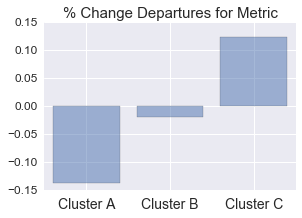

In [68]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_D_4met)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Change Departures for Metric', fontsize=15)
    
plt.show()


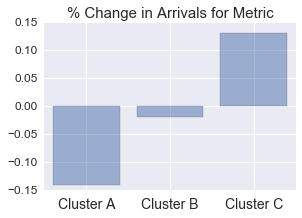

In [69]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_A_4met)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Change in Arrivals for Metric', fontsize=15)
    
plt.show()

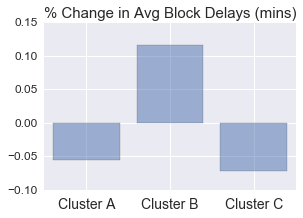

In [70]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_avg_block_del)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('Change in Avg Block Delays', fontsize=18)
plt.title('% Change in Avg Block Delays (mins)', fontsize=15)
    
plt.show()

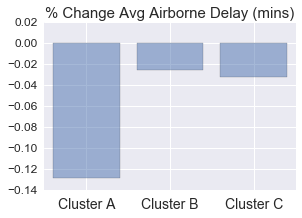

In [71]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_avg_airborne_del)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Change Avg Airborne Delay (mins)', fontsize=15)
    
plt.show()

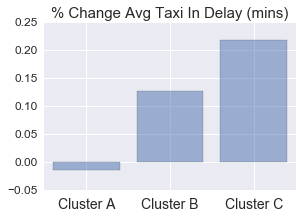

In [72]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_avg_taxi_in_del)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Change Avg Taxi In Delay (mins)', fontsize=15)
    
plt.show()

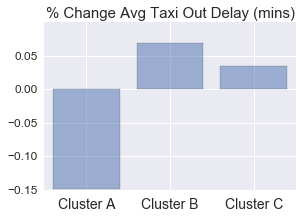

In [73]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_avg_taxi_out_del)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Change Avg Taxi Out Delay (mins)', fontsize=15)
    
plt.show()


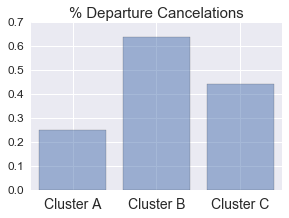

In [74]:
fig = plt.figure(figsize = (4.5,3))

objects = (gbdf.cluster_name)
y_pos = np.arange(len(gbdf.cluster_name))
performance = (gbdf.Chg_D_cancel)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 14)
# plt.xlabel('Cluster', fontsize=18)
plt.yticks(fontsize=12)
# plt.ylabel('% On Time Gate Arrival', fontsize=18)
plt.title('% Departure Cancelations', fontsize=15)
    
plt.show()


## Clustering Take-aways:


#### Cluster A:
* There are 20 airports represented with average departures of 68,146 ranging from 955-205,899. These are the smallest airports in the study.
* These airports have had a significant decline in traffic from 5 years ago with both Departures and Arrivals down nearly -15%.
* Average block delays (total delays from gate-to-gate) were down about 5% from 5 years ago.
* % Change in Airborne Delays is down about 13% from 5 years ago, though the decline in traffic must play a part in this.
* Average Taxi Out Delays have also plummeted
* These airports have the lowest percent of departure cancellations by far.


#### Cluster B: 
* There are 36 airports represented with average departures of 77,477 ranging from 5,546-245,284. 
* There has been little change in traffic, Arrivals or Departures, from 5 years ago.
* Average Block Delays (total delays from gate-to-gate) grew over 10% while the other two clusters have declined in that time. This is probably enough of an indicator that this is the cluster with the real problems.
* % Change in Average Taxi In Delays are up about 13% from 5 years ago.
* Taxi Out Delays have grown over 5% from 5 years ago.
* More departures were cancelled among these airports than either of the other clusters.


#### Cluster C:
* There are 13 airports represented with average departures of 225,746 ranging from 32,791-428,954. These are the largest airports in the study. 
* Traffic to these airports have grown at nearly the same rate as Cluster 0 has lost.
* Average block delays (total delays from gate-to-gate) were down over 5% from 5 years ago.
* Average Taxi In Delays are up over 20% from 5 years ago.


## Summary
While Cluster C has its problems, Cluster B is clearly dragging the rest of the system down.
Their biggest problems seem to stem from weakening taxi systems with Taxi In delays up +13% from 5 years ago and Taxi Out delays are up +5%. 

While Taxi In delays are worse for Cluster C they have the "excuse" of traffic having grown substantially in that time while Cluster B hasn't changed much.

This seems to be a very surmountable barrier that simply calls for organizational and operational improvements.

Here are the details for Cluster B airports

In [75]:
# this code largely repeats what had been done earlier in "meet the clusters" but includes more details

# cluster_meet = ['ap_name','cluster_name', 'D_4met']
# clusters = pd.DataFrame(df14c[cluster_meet])

df14c.rename(columns={'ap_name':'ap_code'}, inplace=True)

# # then reset the indeces for that df and the df dictionary made earlier so that they can merge nicely
df14c.reset_index(drop=True, inplace=True)
ap_dict_df.reset_index(drop=True, inplace=True)


# # #bring them both together
clustBdf = pd.merge(ap_dict_df, df14c, how='right', sort='True', on=['ap_code'])


# # # move columns around a bit
# # clusters[['cluster_name', 'D_4met', 'ap_code','airport']] = clusters[['cluster_name','ap_code','airport','D_4met']]
# # clusters.rename(columns={'D_4met':'ap_code', 'ap_code':'airport', 'airport':'Total Departures'}, inplace = True)

# # # clean the head
# # clusters.pop('ap_name');

# # # voila!
# clustdf.info()
# clustdf.head()


# # isolating Cluster B
clustBdf = pd.DataFrame(clustBdf.loc[clustBdf['cluster_name'] == 'Cluster B'])

# # sorting by ap_code and resetting the index
clustBdf.sort_values(by='ap_code', inplace=True)

# clustBdf.info()

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 805 non-null object
ALIAS                                 805 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

In [77]:
active_clusters = pd.concat([cluster0, cluster1, cluster2], axis = 0)
active_clusters.info()

df14_clusters = pd.DataFrame(df.loc[df['Year'] == 2014])

# there are a few things that I'm going to take out because I can't see them being relevent. 

df14_clusters.drop(['Key','year','COUNTY','CITY','airport','LocID', 'ALIAS', "Boundary Data Available",\
                    'Facility Type'], axis=1, inplace=True)

# now we can rename everything. again. Yay.

df14_clusters.columns = ['ap_code', 'year','D_cancel', 'A_cancel','D_divert','A_divert', 'faa_region',\
                     'state','ap_type','lat','long','D_4met','A_4met', 'pct_oT_gate_D',\
                     'pct_oT_ap_D', 'pct_oT_gate_A', 'avg_gate_D_delay','avg_taxi_out_time', 'avg_taxi_out_del',\
                     'avg_ap_D_del','avg_airborne_del', 'avg_taxi_in_del', 'avg_block_del','avg_gate_A_del']

# make room for clusters!

# sorting by ap_code and resetting the index
df14_clusters.reset_index(drop=True, inplace=True)
active_clusters.reset_index(drop=True, inplace=True)

# df14_clusters.merge(active_clusters, left_on="ap_code")

clustBdf = pd.merge(active_clusters, df14_clusters, how='left', sort='True', on=['ap_code'])

# take out the year column that came with the merge

clustBdf.pop('year')

# # isolating Cluster B
clustBdf = pd.DataFrame(clustBdf.loc[clustBdf['cluster_name'] == 'Cluster B'])

# don't need this anymore
clustBdf.pop('cluster_name')

# # sorting by ap_code
clustBdf.sort_values(by='ap_code', inplace=True)

# but still probably want to know that these are the cluster b airports
clustBdf.rename(columns={'ap_code':'Clust_B_airports'}, inplace=True)

# a little more cleanup
clustBdf.rename(columns={'D_4met_x':'D_4met'}, inplace=True)
clustBdf.pop('D_4met_y')

pd.options.display.max_columns = 999
clustBdf.head(40)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 12
Data columns (total 4 columns):
ap_code         69 non-null object
airport         68 non-null object
cluster_name    69 non-null object
D_4met          69 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.7+ KB


,Clust_B_airports,airport,D_4met,D_cancel,A_cancel,D_divert,A_divert,faa_region,state,ap_type,lat,long,A_4met,pct_oT_gate_D,pct_oT_ap_D,pct_oT_gate_A,avg_gate_D_delay,avg_taxi_out_time,avg_taxi_out_del,avg_ap_D_del,avg_airborne_del,avg_taxi_in_del,avg_block_del,avg_gate_A_del
0,ABQ,ALBUQUERQUE INTL SUNPORT,33292,315.0,274.0,66.0,37.0,AGL,MI,Public Use,44.988583,-85.198361,33137,0.7451,0.7148,0.7320,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72
3,AUS,AUSTIN-BERGSTROM INTL,60588,484.0,435.0,88.0,97.0,ASO,GA,Federalized/Commercial,33.948583,-83.326361,60264,0.7627,0.7382,0.7222,14.16,11.76,2.06,15.59,2.25,1.08,2.88,16.20
4,BDL,BRADLEY INTL,39279,467.0,421.0,57.0,32.0,AGL,IL,Public Use,38.606556,-87.726694,39109,0.7953,0.7605,0.7569,12.64,12.76,2.58,14.39,2.34,0.95,2.64,14.79
5,BHM,BIRMINGHAM-SHUTTLESWORTH INTL,23725,336.0,311.0,46.0,30.0,ASW,TX,Public Use,27.740889,-98.026944,23682,0.7421,0.7183,0.7016,15.58,12.19,2.05,16.75,1.74,0.93,2.93,16.70
6,BNA,NASHVILLE INTL,70497,1266.0,1222.0,152.0,60.0,ACE,IA,Public Use,41.992056,-93.621833,70414,0.7404,0.7064,0.7364,15.44,12.15,2.71,17.31,1.85,1.21,3.01,15.40
8,BUF,BUFFALO NIAGARA INTL,34314,612.0,562.0,46.0,27.0,AGL,MN,Public Use,45.227528,-96.004333,34112,0.7584,0.7237,0.7376,15.53,12.17,2.42,17.26,2.33,0.70,2.50,15.96
9,BUR,BOB HOPE,30148,427.0,403.0,36.0,39.0,ASW,LA,Public Use,30.346344,-89.820800,29885,0.7821,0.7613,0.7657,11.30,10.86,1.95,12.58,2.05,0.52,1.84,12.19
10,BWI,BALTIMORE/WASHINGTON INTL THURGOOD MARSHAL,110589,1588.0,1549.0,213.0,181.0,AAL,AK,Public Use,70.467111,-157.435667,110243,0.7159,0.6517,0.7672,16.10,13.34,3.97,19.40,3.27,1.74,2.75,13.73
11,CLE,CLEVELAND-HOPKINS INTL,60369,1282.0,1280.0,124.0,74.0,AGL,WI,Public Use,44.926285,-89.627002,60247,0.7761,0.7203,0.7512,15.10,13.37,3.36,17.84,2.47,1.14,2.78,16.30
14,DAL,DALLAS LOVE FIELD,59618,654.0,733.0,79.0,115.0,AEA,VA,Public Use,37.207639,-80.407833,59515,0.6465,0.6110,0.7078,18.04,10.31,2.28,20.04,2.52,1.36,2.47,16.19


### Next steps

It would be significant to see meteorological data, which I have to imagine the FAA collects, to show whether temperature and precipitation have seen significant shifts in this time.

It could be useful to see whether there is any difference in monthly numbers. Has tourism increased?

Once we get down to the individual airports that we need to consider it would be good to see whether there have been changes in the airlines serving the airport or in the sources / destinations of the planes. If flights from Denver tend to be late and they've just started a new direct flight from Denver to DC then the delays in DC would change.
